This is the overall code to:
    1) Take the broadband r image, convert to nanomaggies and AB mags
    2) Add in background
    3) Produce an error image according to Poisson statistics (+ background + readnoise)
    4) Produce an error spectrum according to the same statistics (at each wavelength)
    5) Prepare to entre into ppxf according to the MaNGA specs

In [111]:
import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits


from astropy.cosmology import WMAP9 as cosmo

import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches

import sys 

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()




In [112]:
'''This code block reads in the broadband images and then will open the broadband extension,
...
'''
a=pyfits.open('q0.5_fg0.3_allrx10/broadband_200.fits')


#So the shape of thie CAMERA(#)-BROADBAND is 5x300x300 where each 
#of the first dimension is the SDSS filter (ugriz) [we want 2]

'''Next try to extract the broadband filters'''
''''CAMERA[N]-BROADBAND', which are data cubes of dimension 
[300 pixels] x [300 pixels] x [5 sdss filters]  and contain 
the actual images
Units are surface brightness in units of: 
IMUNIT  = 'W/m/m^2/sr'         / Pixel quantity is surface brightness           
UNITCONV= 9.45238524920703E-35 / [m^2/(kpc^2)]

Spatially, each pixel is 0.5 kpc for the early stage and 0.1666 kpc for the late stage'''

plt.clf()

camera_data = a['CAMERA0-BROADBAND'].data
camera_header = a['CAMERA0-BROADBAND'].header



xs = np.linspace(0,shape(camera_data[0])[0]-1,shape(camera_data[0])[0])
xs_kpc = [0.1666*x for x in xs]

'''First make a plot of all the different filters side by side'''
fig=plt.figure()
ax0=fig.add_subplot(1,5,1)
ax0.imshow(camera_data[0], vmin=0, vmax=15)
ax0.set_title('u band')
plt.axis('off')

ax1=fig.add_subplot(1,5,2)
ax1.imshow(camera_data[1], vmin=0, vmax=15)
ax1.set_title('g band')
plt.axis('off')

ax2=fig.add_subplot(1,5,3)
ax2.imshow(camera_data[2], vmin=0, vmax=15)
ax2.set_title('r band')
plt.axis('off')

ax3=fig.add_subplot(1,5,4)
im3=ax3.imshow(camera_data[3], vmin=0, vmax=15)
ax3.set_title('i band')
#plt.colorbar(im3, orientation='horizontal')
plt.axis('off')

ax4=fig.add_subplot(1,5,5)
ax4.imshow(camera_data[4], vmin=0, vmax=15)
ax4.set_title('z band')
plt.axis('off')
savefig('../MaNGA_papers/Paper_I/all_filters.pdf')




In [113]:
'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
#first, go from specific intensity (because we have per steradian) to 
#janskies (W/Hz/m^2)
c = 299792.458*1000#to get into m/s

#this 1.35e-6 comes from the arcsin(R_sky/Distance to object)
#the answer needs to be in radians

#J=10^-26 W/m^2/Hz, so units of flux density
#reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html
#We need to go from a spectral brightness (I_nu) which is in m units
#To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)

#So you need to multiply the Fν by c / λ^2 to convert it into Fλ. 
#But we are not done yet! Recalling from above, the units of Fλ 
#are not an energy density. You need to get another factor of λ 
#in there to make the units work out to be energy density: 
#calculate λFλ to get units of ergs/s/cm^2.

#1.35e-6 comes from: sin^-1(pixelscale=0.166666#kpc/pix/ comoving distance in kpc)
pixelscale=0.166666#kpc/pix/
d_a = cosmo.angular_diameter_distance(0.03).value#, **fidcosmo)
d_co = cosmo.comoving_distance(0.03).value
d_lum = cosmo.luminosity_distance(0.03).value 
print("Angluar-diameter distance to z=0.03 is", 1000*(d_a), 'kpc')
print("Comoving distance to z=0.03 is", 1000*((d_co)), 'kpc')
print("Luminosity distance to z=0.03 is", 1000*((d_lum)), 'kpc')



#here's a good review of all the different distances
#http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html


Janskies=np.array(10**(26)*camera_data[2]*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
#A Jansky is 10−26 watts per square metre per hertz.



nanomaggy=Janskies/(3.631*10**(-6))




plt.imshow(np.flipud(nanomaggy),vmin=0, vmax=2)
plt.ylabel(r'kpc [0.1666/pix]')
plt.xlabel(r'kpc [0.1666/pix]')
cb1=plt.colorbar()
cb1.set_label('r-band Flux Density [nanomaggies]')
savefig('pyplots_q0.5_fg0.3_allrx10/200_CAMERA0_2_nanomaggy.pdf')

'''Now convert into the correct background:)'''

#nanomaggies and stuff: (Finkbeiner et al. 2004)

'''The average background and std as well as the readnoise and gain
are from another code of mine:
    SDSS_noise_imaging/SDSS_r_imaging.ipynb'''



sky_resids_mine=np.random.normal(0.01955593,0.0042225,shape(nanomaggy))
poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
poisson_plus_nanomags = poisson_plus*1367.29546
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)

im0=ax0.imshow(np.flipud(nanomaggy), vmin=0, vmax=5)
ax0.set_title(r'Before')
plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')

ax1=fig.add_subplot(1,2,2)


im1=ax1.imshow(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2, vmin=0, vmax=5)
ax1.set_title(r'After')
plt.colorbar(im1,label=r'Flux [Nanomaggies]', orientation='horizontal')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/background_added.pdf')


fig=plt.figure()
ax1=fig.add_subplot(1,1,1)


im1=ax1.imshow(poisson_plus, vmin=0, vmax=0.1)
ax1.set_title(r'Error Image')
plt.colorbar(im1,label=r'Flux [Counts]', orientation='vertical')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/error_fake.pdf')


mag=22.5-2.5*np.log10(nanomaggy)

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)


im1=ax1.imshow(np.flipud(mag), cmap='afmhot_r', vmin=0, vmax=40)
#ax1.set_title(r'Magnitude Image')
cb1=plt.colorbar(im1,label=r'Flux [m$_{\mathrm{AB}}$]', orientation='vertical')

cb1.ax.invert_yaxis()
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/magnitude.pdf')


'''write it out so that GALFIT can use it'''
outfile = 'q0.5_fg0.3_allrx10/test_out.fits'

hdu = fits.PrimaryHDU(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2)
hdu.writeto(outfile, clobber=True)

outfile = 'q0.5_fg0.3_allrx10/test_out_error.fits'

hdu = fits.PrimaryHDU(poisson_plus)
hdu.writeto(outfile, clobber=True)



Angluar-diameter distance to z=0.03 is 125146.00822706954 kpc
Comoving distance to z=0.03 is 128900.38847388163 kpc
Luminosity distance to z=0.03 is 132767.4001280981 kpc


kernel 2.488741675955623


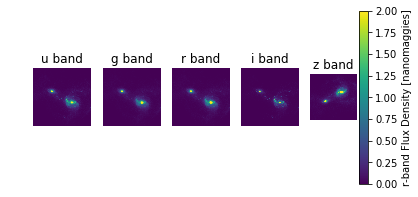

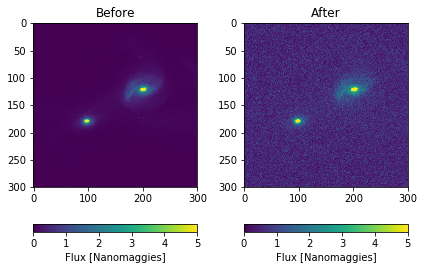

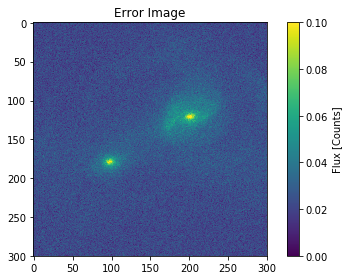

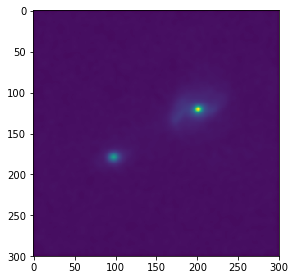

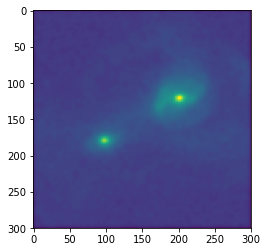

In [114]:
'''Now, I need to convolve them with the Gaussian Kernel that represents the size of the PSF'''
#PSF = 1.61 arcsec
plt.clf()

from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift to get the kpc/arcmin scaling

sigma=1.61/2.355#apparently the preimage sigma is not large :)
##kpc/pix is the pixelscale
##conversion factor is kpc/"
#1.61 is the FWHM in arcsec of the psf
#pixelscale is kpc/pix
kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixelscale
print('kernel', kernel_sigma_pix)

gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



#result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
result = convolve(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2, gaussian_2D_kernel)
result_error = convolve((poisson_plus_nanomags), gaussian_2D_kernel)
#result_2 = convolve_fft(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
result_counts = convolve((np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2), gaussian_2D_kernel)
result_counts_error = convolve((poisson_plus), gaussian_2D_kernel)
#poisson plus is the error on counts
plt.imshow(result)
plt.show()
plt.imshow(result_error)
plt.show()


fig=plt.figure()

ax3=fig.add_subplot(1,3,1)
im3=ax3.imshow((nanomaggy), vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax3.set_title(r'')
plt.colorbar(im3, orientation='horizontal')
plt.axis('off')

ax0=fig.add_subplot(1,3,2)



im0=ax0.imshow((nanomaggy)+1367.29546*sky_resids_mine**2, vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax0.set_title(r'Background Added')
plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')
plt.axis('off')
ax1=fig.add_subplot(1,3,3)


im1=ax1.imshow(np.flipud(result), vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax1.set_title(r'PSF Applied')
plt.colorbar(im1, orientation='horizontal')
#plt.tight_layout()
plt.axis('off')
savefig('../MaNGA_papers/Paper_I/background_added_convolved.pdf')


outfile = 'out_convolved.fits'
hdu = fits.PrimaryHDU(result)
hdu.writeto(outfile, clobber=True)

outfile = 'out_sigma_convolved.fits'
hdu = fits.PrimaryHDU(result_error)
hdu.writeto(outfile, clobber=True)

In [115]:
import subprocess
#subprocess.call("cd GALFIT_folder/", shell=True)
subprocess.call("galfit galfit.feedme", shell=True)



0

Effective Radius in pixels 50.3403 +/- 0.8390


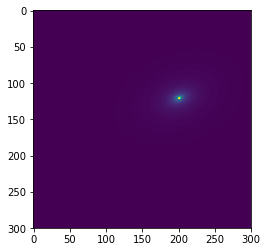

In [116]:
'''Now open the galfit result and get the effective radius '''

plt.clf()
output='imgblock_convolved.fits'
out=pyfits.open(output)
#2 is model
#3 is residual map

print('Effective Radius in pixels',out[2].header['1_RE'])
#also, galfit.xx is the final output
#fit.log has the chi squared values and stuff

fig=plt.figure()

plt.imshow(out[2].data)
plt.show()


galfit_input=out[1].data
galfit_model=out[2].data
galfit_resid=out[3].data
fig=plt.figure()

ax1 = fig.add_subplot(131, aspect='equal')
ax1.set_title('Data')

pixelscale=0.166666#kpc/pix
#spacing=((kpc_arcmin.value/60))/pixelscale
#axis is 100x100 pixels
ticklocs=[0,25,50,75,100]

v = np.linspace(0, 0.01, 2, endpoint=True)

kpc=[round(pixelscale*(x-50),1) for x in ticklocs]

im1=ax1.imshow(galfit_input[75:175,150:250], cmap='viridis_r', vmin=0, vmax=7)
ax1.set_xticks(ticklocs)
ax1.set_xticklabels(kpc)
ax1.set_yticks(ticklocs)
ax1.set_yticklabels(kpc)
plt.colorbar(im1, orientation='horizontal')


ax2 = fig.add_subplot(132, aspect='equal')
ax2.set_title('Galfit Model')
im2=ax2.imshow(galfit_model[75:175,150:250], cmap='viridis_r', vmin=0, vmax=7)
ax2.set_xticks(ticklocs)
ax2.set_xticklabels(kpc)
ax2.set_yticks(ticklocs)
ax2.set_yticklabels(kpc)
plt.colorbar(im2, orientation='horizontal', label=r'Flux [nanomaggies]')


ax3 = fig.add_subplot(133, aspect='equal')
ax3.set_title('Residuals')
im3=ax3.imshow(galfit_resid[75:175,150:250], cmap='viridis_r', vmin=-1, vmax=1)
v=np.linspace(-1,1,3)
ax3.set_xticks(ticklocs)
ax3.set_xticklabels(kpc)
ax3.set_yticks(ticklocs)
ax3.set_yticklabels(kpc)
plt.colorbar(im3, orientation='horizontal', ticks=v)
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/Galfit_ex.pdf')


In [117]:
'''Nice, now its time to think about convolving the spectrum itself'''
'''First, the spectrum
Second, the code to extract the spectrum
Third, the ppxf code
Fourth, the thing that incorporates them all together'''

'First, the spectrum\nSecond, the code to extract the spectrum\nThird, the ppxf code\nFourth, the thing that incorporates them all together'

In [118]:
#mcrx_200 files are the full data cube 300x300xnlambdas
#so we need to add poisson noise to each spectrum (don't actually degrade)
#just make an error file
spec=pyfits.open('q0.5_fg0.3_allrx10_sunruns/mcrx_200.fits')
print(spec.info())
#So spec[25] is a camera HDU
print(shape(spec[25]))
CAMERA0=spec[25]
Ang=[x[0]*10**(10) for x in spec[5].data]#

xmin=150
xmax=200
ymin=175
ymax=225

integrated=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=(1,2))
#use a tuple to sum along two different axes



plt.clf()


#Try to figure out where you're targeting on the thing


f, axarr = plt.subplots(2)
axarr[0].plot(Ang,(integrated))
axarr[0].set_xlim([0,30000])
axarr[0].set_title('Integrated Spectrum')
axarr[0].set_xlabel(r'$\lambda$ [$\AA$]')
axarr[0].set_ylabel(r'Surface Brightness [$W/m/m^2/sr$]')

#now draw a box where you're making the SED cuts
rect = patches.Rectangle((xmin+(xmax-xmin)/2,ymin-(ymax-ymin)/2),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')
# (upper left corner in x and y, x length, y length)
# Add the patch to the Axes
axarr[1].add_patch(rect)



#plot the broadband thing
'''broadband=np.sum(CAMERA0.data,axis=0)
print(broadband)
ax1=axarr[1].imshow((broadband),vmax=10000)
axarr[1].axhline(y=100, color='red')
axarr[1].axvline(x=100, color='red')

axarr[1].axhline(y=200, color='red')
axarr[1].axvline(x=200, color='red')


plt.colorbar(ax1)'''


broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
ax2=axarr[1].imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
axarr[1].set_xlabel(r'0.166 / kpc')
plt.tight_layout()
#plt.show()
savefig('pyplots_q0.5_fg0.3_allrx10/200_SED_fiber.pdf')



'''Now I'm going to use plotting_fiber to make a pretty overlay of the MaNGA fiber as 
I begin to MaNGA-ize everything'''

cosmo.H(0)  
#Quantity 69.32 km / (Mpc s)>
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift  
print(kpc_arcmin.value/60, 'kpc per arcsec')

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

pixelscale=0.166666#kpc/pix
spacing=(2.5*(kpc_arcmin.value/60))/pixelscale
radius = (1*(kpc_arcmin.value/60))/pixelscale
correction = (0.25*(kpc_arcmin.value/60))/pixelscale


'''plotting_fiber(91)



The fibers in each bundle are 2.5" apart




#now draw a box where you're making the SED cuts

print('doin geometry',np.sin(math.radians(60)))


    



broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
ax1.set_xlabel(r'0.166 / kpc')
plt.tight_layout()
plt.show()

plt.clf()'''

plotting_fibers_r_e(37.57)#input is the effective radius in pixels FROM GALFIT

'''The fibers in each bundle are 2.5" apart'''




#now draw a box where you're making the SED cuts

print('doin geometry',np.sin(math.radians(60)))


    



broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
#ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
ax1.imshow(np.flipud(result), vmin=0, vmax=5)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
ax1.set_xlabel(r'0.166 / kpc')
#plt.tight_layout()
#plt.show()

savefig('pyplots_q0.5_fg0.3_allrx10/Simulated_fiber_convolved.pdf')


Filename: q0.5_fg0.3_allrx10_sunruns/mcrx_200.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      20   ()              
1    SCATTERING_LAMBDAS  BinTableHDU     33   0R x 5C      [J, D, L, D, J]   
2    BHMODEL     BinTableHDU     14   0R x 0C      []   
3    GADGET      BinTableHDU     94   0R x 0C      []   
4    GRIDSTRUCTURE  BinTableHDU     20   1795657R x 1C   [L]   
5    LAMBDA      BinTableHDU     16   970R x 2C    [D, D]   
6    MAKEGRID    BinTableHDU     30   0R x 0C      []   
7    SFRHIST     BinTableHDU     83   0R x 0C      []   
8    STELLARMODEL  BinTableHDU     60   0R x 0C      []   
9    MCRX        BinTableHDU     62   0R x 0C      []   
10   CAMERA0-PARAMETERS  ImageHDU        33   (300, 300)   float32   
11   CAMERA1-PARAMETERS  ImageHDU        33   (300, 300)   float32   
12   CAMERA2-PARAMETERS  ImageHDU        33   (300, 300)   float32   
13   CAMERA3-PARAMETERS  ImageHDU        33   (300, 300)   float32   
14   CAME

In [134]:
def extract_spec( xmax, ymin, rad):
    
    plt.clf()
    '''This one is going to extract spectra and then convolve them with a Gaussian Kernal
    with resolution 72 km/s'''
    '''Also convolves with a Gaussian'''
    center_x=xmax
    center_y=ymin
    
    radius = arc_to_pix(rad)
    
    '''Step 1: Make a new image of just that spec'''
    #np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
    x_coords=[]
    y_coords=[]
    new_cube=[]
    '''create an empty masked array'''
    mask_2d=np.zeros((len(CAMERA0.data[:,0,0]),len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))

    #    masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)
    for i in range(len(CAMERA0.data[0,:,0])):
        for j in range(len(CAMERA0.data[0,0,:])):
            if (center_x-i)**2+(center_y-j)**2 < radius**2:
                x_coords.append(i)
                y_coords.append(j)
                new_cube.append(CAMERA0.data[:,i,j])
                
            else:
                mask_2d[:,j,i]=1
    masked_cube= ma.masked_array(CAMERA0.data[:,:,:], mask=mask_2d)
    plt.imshow(np.sum(masked_cube,axis=0), interpolation='None', vmin=0, vmax=1e4)
    plt.colorbar()
    plt.show()
    
    plt.clf()

    integrated=np.sum(masked_cube,axis=(1,2))
    
    #def arc_to_pix(arc):
    #return (arc*(kpc_arcmin.value/60))/pixelscale
    '''resolution is 2000'''
    res=[x/2000 for x in Ang]
    
    plt.plot(Ang,res)
    plt.axhline(y=np.mean(res))
    plt.show()
    
    g = Gaussian1DKernel(np.mean(res))

    # Convolve data
    z = convolve(integrated, g, boundary='extend')
    
    '''f, axarr = plt.subplots(2)
    axarr[0].plot(Ang,(integrated))
    axarr[0].plot(Ang,z,'red')
    axarr[0].set_xlim([3000,8000])
    axarr[0].set_title('Integrated Spectrum')
    axarr[0].set_xlabel(r'$\lambda$ [$\AA$]')
    axarr[0].set_ylabel(r'Surface Brightness [$W/m/m^2/sr$]')
    
    #now draw a box where you're making the SED cuts
    rect = patches.Circle((center_x,center_y),radius,linewidth=2,edgecolor='red',facecolor='none')
    axarr[1].add_patch(rect)
    
  
    
    
    broadband_cut=np.sum(masked_cube,axis=0)
    #MIDDLE DIMENSION IS ACTUALLY THE YS
    ax2=axarr[1].imshow(np.sum(masked_cube,axis=0), interpolation='None')
    #axarr[1].axhline(y=xmin,  color='white')
    #axarr[1].axhline(y=xmax,  color='white')
    #axarr[1].axvline(x=ymin, color='white')
    #axarr[1].axvline(x=ymax, color='white')
    axarr[1].set_xlabel(r'0.166 / kpc')
    plt.tight_layout()
    plt.show()'''
    #savefig('pyplots_q0.5_fg0.3_allrx10/extract_fiber.pdf')
    
    #image=CAMERA0.data[:,center_x-]
    #rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
    #            ax1.add_patch(rect)
    return Ang, integrated, z

def arc_to_pix(arc):
    return (arc*(kpc_arcmin.value/60))/pixelscale

def plotting_fiber(n_fibers):
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

        
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        print(i,i/2,corr)
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(length_arc)+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(len(index_1)+1.5)*np.sin(math.radians(60))*spacing),xycoords='data', size=15, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    
    
    
def plotting_fibers_r_e(effective_radius):
    
    '''input is the effective radius
    1) Convert r_e to arcsec
    2) Determine which fiber to use'''
    arcs_totes=((2*1.5*effective_radius)*pixelscale)/(kpc_arcmin.value/60)#pixelscale is kpc/pix
    #arcs_totes=1.5*((effective_radius*(kpc_arcmin.value/60))/pixelscale)
    
    
    '''Fibers are spaced as follows:
    19: 12.5
    37: 17.5
    61: 22.5
    91: 27.5
    127: 32.5'''
    
    if arcs_totes > 32.5:
        n_fibers=127
    else:
        if arcs_totes > 27.5:
            n_fibers=91
        else:
            if arcs_totes > 22.5:
                n_fibers=61
            else:
                if arcs_totes > 17.5:
                    n_fibers=37
                else:
                    n_fibers=19
    print('arcs_totes', arcs_totes, 'Number of fibers', n_fibers)
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

        
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        print(i,i/2,corr)
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(length_arc)+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(len(index_1)+1.5)*np.sin(math.radians(60))*spacing),xycoords='data', size=15, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    
    
    
       

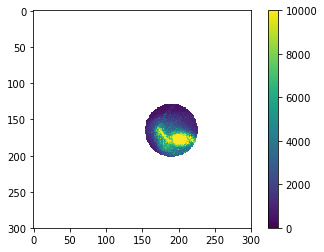

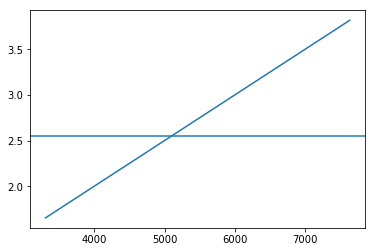

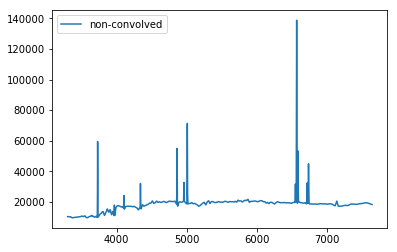

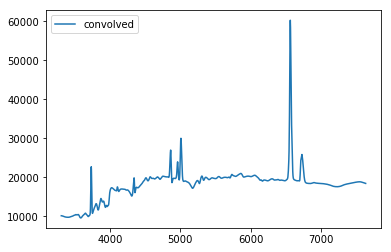

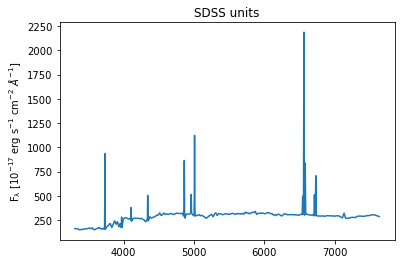

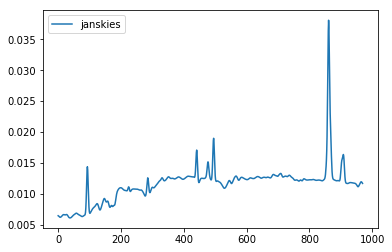

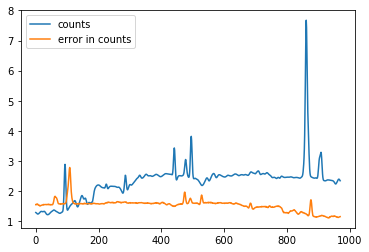

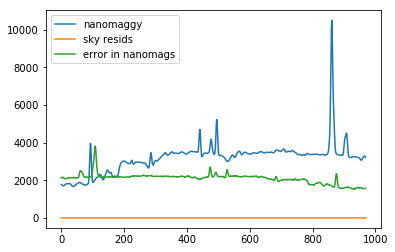

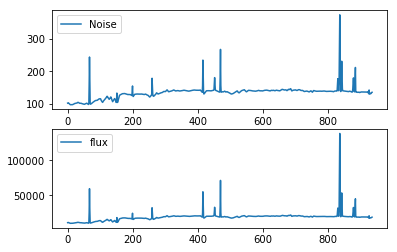

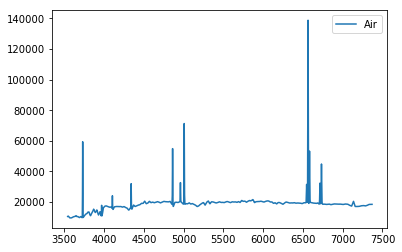

frac 1.001094407 3546.08985847 3542.2132355
<class 'numpy.ndarray'>


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


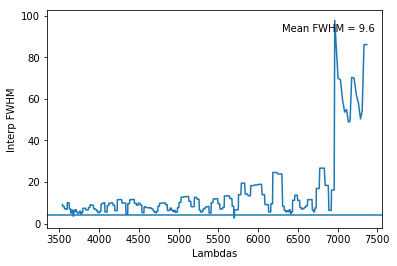

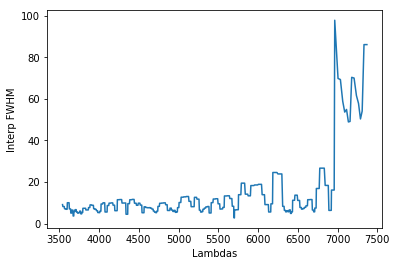

velscale 327.915562011


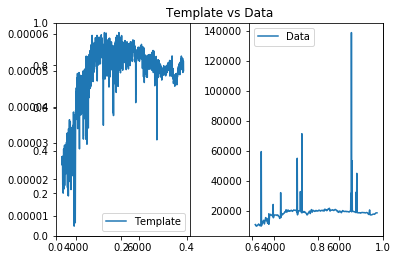

wavelength lims [3900, 4100]


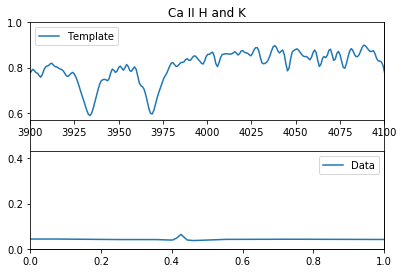

wavelength lims [4230, 4270]


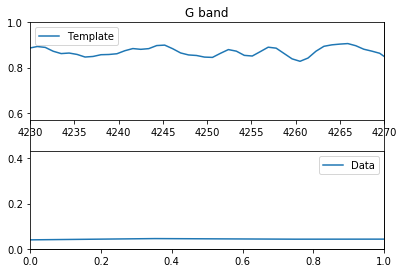

wavelength lims [5100, 5300]


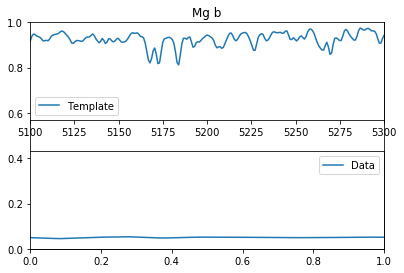

wavelength lims [5800, 5950]


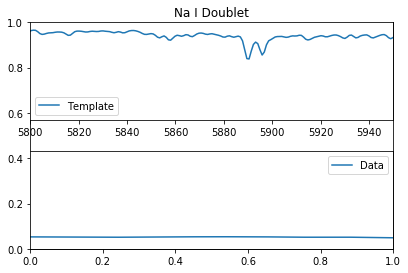

len gal 935 len temp pre conv 4300
len gal 935 len temp post conv 3376


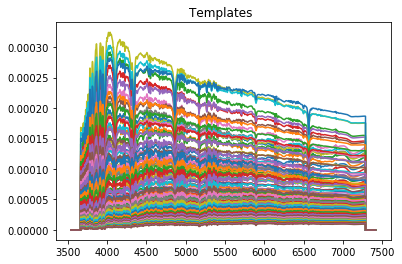

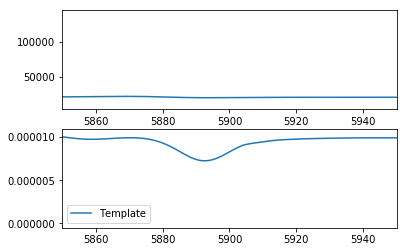

must improve chi2 by:  40.6693988153
input vel 8861.50597953


AssertionError: STAR length cannot be smaller than GALAXY

In [141]:
'''create a loop to find the stellar velocity at all points'''
xmin=150
xmax=200
ymin=175
ymax=225


stell_vel = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_vel_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
#for i in range(len(CAMERA0.data[0,:,0])):
#    for j in range(len(CAMERA0.data[0,0,:])):
for i in range(1):#was 20
    for j in range(1):   
        xs=190+i
        ys=165+j
        y=extract_spec(xs,ys,10) #was 0.01
        x=y[0]
        spec_non_convolved=y[1]
        spec_convolved=y[2]
        
        plt.plot(x,spec_non_convolved, label='non-convolved')
        plt.legend()
        plt.show()
        plt.plot(x,y[2], label='convolved')
        plt.legend()
        plt.show()

        #y=ppxf_from_J1354(x, spec_non_convolved,'no', 1, 0.04,0,0.01)
        
        
        
        
        c = 299792.458*1000#to get into m/s


        pixelscale=0.166666#kpc/pix/

        d_lum = cosmo.luminosity_distance(0.03).value 

        Janskies=np.array(10**(26)*spec_convolved*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
        #A Jansky is 10−26 watts per square metre per hertz.

        f_lambda=np.array(10**17*(10**7*spec_non_convolved*(pixelscale/(1000*d_lum))**2)/(100**2*10**10))
        #should give the flux density in units of erg cm^-2, s^-1, A^-1
        
        plt.plot(Ang, f_lambda)
        plt.ylabel(r'F$_{\mathrm{\lambda}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
        plt.title('SDSS units')
        plt.show()

        nanomaggy=Janskies/(3.631*10**(-6))
        
        counts=nanomaggy/1367.29546
        
        sky_resids_mine=np.random.normal(0.01955593,0.0042225,shape(nanomaggy))
        poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
        poisson_plus_nanomags = poisson_plus*1367.29546
        
        plt.plot(Janskies, label='janskies')
        plt.legend()
        plt.show()
        
        
        plt.plot(counts, label='counts')
        plt.plot(poisson_plus, label='error in counts')
        plt.legend()
        plt.show()
        
        plt.plot(nanomaggy, label='nanomaggy')
        plt.plot(sky_resids_mine, label='sky resids')
        plt.plot(poisson_plus_nanomags, label='error in nanomags')
        plt.legend()
        plt.show()
        
        
        c=2.99792458e5
        #we need to convert to counts so we can extract
        #an error spectrum
        y=ppxf_mileshc(x,spec_non_convolved,np.sqrt(spec_non_convolved),5,'yes',0,'yes',8,-1,0,0,0, c*np.log(1 + 0.03),  100, 2)
        '''also calculate the redshift from this'''


        z_input=0.04
        
        red_vel_input=c*np.log(1 + z_input)
        
        z_stars=np.exp( y[3]     /c)-1

        stell_vel[xs,ys]=(y[3]-red_vel_input)/(1+z_stars)
        
        print('stellar velocity offset', (y[3]-red_vel_input)/(1+z_stars))
        #stell_vel_e[xs,ys]=abs((y[2]/y[3])*((y[3]-red_vel_input)/(1+z_stars)))
        stell_vel_e[xs,ys]=(y[2])
        stell_disp[xs,ys]=y[5]
        stell_disp_e[xs,ys]=y[6]
        #this is the percent error multiplied by the corrected stellar velocity
        
  
    


In [ ]:
'''This is the type of ppxf that replicates the results for MaNGA'''
def ppxf_mileshc(t,flux,noise,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1

 
    t=np.array(t)
    flux=np.array(flux)
    noise=np.array(noise)
        
        
    
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540)
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var_scaled = noise
    
    if plot=='yes':
        fig=plt.figure()
        ax1=fig.add_subplot(2,1,1)
        ax1.plot(var_scaled, label='Noise')
        plt.legend()
        ax2=fig.add_subplot(2,1,2)
        ax2.plot(flux, label='flux')
        plt.legend()
        plt.show()
    galaxy = flux   
    if regularization!=0:
        #TEMPLATES/=np.median(TEMPLATES))
        galaxy/=np.median(galaxy)
    #apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    
    #lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

    if plot=='yes':
        plt.plot(lam_gal, galaxy, label='Air')
        
        plt.legend()
        plt.show()
    
    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
    
    print('frac', frac, lam_gal[1], lam_gal[0])
    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
    #wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
    #print('wdisp',len(wdisp), 'lam_gal', len(lam_gal))
    print(type(lam_gal))
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    x_1=np.linspace(0,len(lam_gal)-2,len(lam_gal)-1)
    fwhm_gal=[2.355*(lam_gal[x+1]-lam_gal[x]) for x in x_1]
    fwhm_gal.append(fwhm_gal[len(x_1)-1])
    fwhm_gal=np.array(fwhm_gal)
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.axhline(y=(lam_gal[-1]-lam_gal[0])/len(lam_gal))
        plt.annotate('Mean FWHM = '+str(round(2.355*((lam_gal[-1]-lam_gal[0])/len(lam_gal)),1)),xy=(0.7,0.9),xycoords='axes fraction')
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    print('velscale', velscale)
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    #fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
 
    
    file_dir = glob.glob('../ppxf/miles_models/Mun*.fits')
    #file_dir = glob.glob('../ppxf/indo_us/IRAF/*.fits')
    #file_dir = glob.glob('../MaNGA_code/practice_logcube/DAP/data/spectral_templates/miles_cluster/*.fits')

    

    hdu = fits.open(file_dir[10])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    
    
    lam_gal_plot = lam_gal/(1+input_z)
    
    lines=['Ca II H and K', 'G band','Mg b', 'Na I Doublet']
    wavelength_limits=[[3900,4100],[4230,4270],[5100,5300],[5800,5950]]
    
    if plot=='yes':
        fig=plt.figure()
        plt.title('Template vs Data')
        ax1=fig.add_subplot(1,2,1)
        ax1.plot(lam_temp,ssp, label='Template')
        
        plt.legend()

        ax2=fig.add_subplot(1,2,2)
        ax2.plot(lam_gal_plot, galaxy, label='Data')
      

        plt.legend()
        plt.tight_layout()
        plt.show()
    
    if plot=='yes':
        for i in range(len(lines)):
            plt.clf()
            fig=plt.figure()
            plt.title(lines[i])
            ax1=fig.add_subplot(2,1,1)
            ax1.plot(lam_temp,ssp, label='Template')
            print('wavelength lims', wavelength_limits[i])
            plt.xlim(wavelength_limits[i])
            ax1.set_yticks([])
            ax1.set_ylabel([])
            ax1.yaxis.set_visible(False)
            
            plt.legend()

            ax2=fig.add_subplot(2,1,2)
            ax2.plot(lam_gal_plot, galaxy, label='Data')
            plt.xlim(wavelength_limits[i])
        
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel([])
            
            ax2.set_xticks([])
            ax2.set_xlabel([])

            plt.legend()
            plt.tight_layout()
            plt.show()
    
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        '''if j==0 and plot=='yes':
            plt.plot(lam_temp, ssp, label='Pre Convolved')'''
        if conv=='yes':
            if j==0:
                print('len gal', len(lam_gal), 'len temp pre conv', len(ssp))
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        if plot=='yes':
            plt.plot(lam_temp,ssp, label='Convolved')
        
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        if j==0:
            print('len gal', len(lam_gal), 'len temp post conv', len(sspNew))
        
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    
   
    if plot=='yes':
        plt.title('Templates ')
        #plt.legend()
        plt.show()
        
        fig=plt.figure()
        ax1=fig.add_subplot(211)
        ax1.plot(lam_gal, galaxy, label='Gal')
        ax1.set_xlim([5850,5950])
        #ax1.set_ylim([0.5,2.0])
        ax2=fig.add_subplot(212)
        ax2.plot(lam_temp, ssp, label='Template')
        ax2.set_xlim([5850,5950])
        plt.legend()
        plt.show()
    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    print('must improve chi2 by: ', np.sqrt(2*len(goodpixels)))

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    print('input vel', vel)
    start = [vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()
    if regularization !=0:
        templates/=np.median(templates)

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              clean=False)#was degree=12

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    
    plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=1, label='Model')

    plt.legend()
    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
    plt.xlim([6275,6400])
    plt.ylim([0.8,1.5])
    plt.show()
    return lam_gal, galaxy, pp.error[0], pp.chi2


